# Relative Vorticity

This notebook shows a simple example of calculation the vertical component of relative vorticity,

$$\zeta = \partial_x v - \partial_y u.$$

For demonstration purposes we will compute the vorticity near the surface, but the method can be applied to any depth.

We will demonstrate three methods for computing relative voritcity:

1. A naïve method of simply converting degrees of longitude/latitude into metres and differentiating.
    This method works if you simply wanna have a look at how the vorticity field looks like.
2. A much more careful way of replicating exactly what the model does for computing the vertical component of relative vorticity.
3. A simpler but accurate method leveraging the functionality of the `xgcm`.

**Requirements:** The `conda/analysis3-20.01` (or later) module on the VDI/gadi (or your own up-to-date cookbook installation).

**Firstly,** load in the requisite libraries:

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
from dask.distributed import Client

import matplotlib
from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amsfonts}',
    r'\usepackage{amssymb}']
rc('text', usetex=False)

import xarray as xr
import xgcm
print("xgcm version ", xgcm.__version__)

xgcm version  0.3.0


Load a `dask` client.

In [2]:
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:46133 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 48 Memory: 202.49 GB


In [3]:
expt = '025deg_jra55v13_iaf_gmredi6'
session = cc.database.create_session()

Various parameters that will be used for computing quantities.

In [4]:
# these are the values used by MOM5
Ω = 7.292e-5 # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m

Load `lon` and `lat` used in the experiment. These datasets can be used for 

In [5]:
lon = cc.querying.getvar(expt, 'geolon_c', session, ncfile="ocean_grid.nc", n=1)
lat = cc.querying.getvar(expt, 'geolat_c', session, ncfile="ocean_grid.nc", n=1)

Calculate the Coriolis parameter $f = 2\Omega \sin(\theta)$, where $\theta$ is latitude.

In [6]:
f = 2*Ω*np.sin(lat*np.pi/180)
f = f.rename('Coriolis')
f.attrs['long_name'] = 'Coriolis parameter'
f.attrs['units'] = 's-1'
f.attrs['coordinates'] = 'geolon_c geolat_c'

Load the $u$ and $v$ velocity snapshots. Then we pick a depth value below the Ekman layer, namely the closest to $z=-30\,m$.

The code `.isel(time=-1)` selects the final snapshot of `u` or `v`. Remove `.isel(time=-1)` to load **all** available snapshots of the flow fields.

In [7]:
depth = 30 #m; avoid the surface Ekman layer by taking the "surface values" at some depth close to the surface

u = cc.querying.getvar(expt, 'u', session, ncfile="ocean.nc")
u = u.isel(time=-1).sel(st_ocean=depth, method='nearest')

v = cc.querying.getvar(expt, 'v', session, ncfile="ocean.nc")
v = v.isel(time=-1).sel(st_ocean=depth, method='nearest')

## Method 1 (naïve computation)

To compute relative vorticity $\zeta = \partial_x v - \partial_y u$ we simply differentiate the velocity components with respect of `lon` (here `xu_ocean` in degrees) and `lat` (here `yu_ocean` in degrees). We then convert the derivatives from units of degrees$^{-1}$ to m$^{-1}$. To do so, we use the value of the radius of the Earth `Rearth` and also take into account that as we go towards the poles the `lon`-grid spacing is scaled by $\cos($ `lat` $)$.

(Note the unicode characters like `ζ` can be used in `python`.)

In [8]:
ζ_naive = v.differentiate('xu_ocean')/(np.pi/180*Rearth*np.cos(np.deg2rad(lat))) - u.differentiate('yu_ocean')/(np.pi/180*Rearth)
ζ_naive = ζ_naive.rename('Relative Vorticity')
ζ_naive.attrs['long_name'] = 'Relative Vorticity, ∂v/∂x-∂u/∂y'
ζ_naive.attrs['units'] = 's-1'

In [9]:
ζ_naive.load()

<xarray.DataArray 'Relative Vorticity' (yu_ocean: 1080, xu_ocean: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * yu_ocean  (yu_ocean) float64 -81.02 -80.92 -80.81 ... 89.79 89.89 90.0
    st_ocean  float64 30.36
  * xu_ocean  (xu_ocean) float64 -279.8 -279.5 -279.2 -279.0 ... 79.5 79.75 80.0
    time      object 2257-06-30 12:00:00
    geolon_c  (yu_ocean, xu_ocean) float32 nan nan nan nan ... nan nan nan nan
    geolat_c  (yu_ocean, xu_ocean) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    long_name:  Relative Vorticity, ∂v/∂x-∂u/∂y
    units:      s-1

We now plot $\zeta$ in the North Atlantic.

In [10]:
maxvalue = 6e-6
levels = np.linspace(-maxvalue, maxvalue, 24)

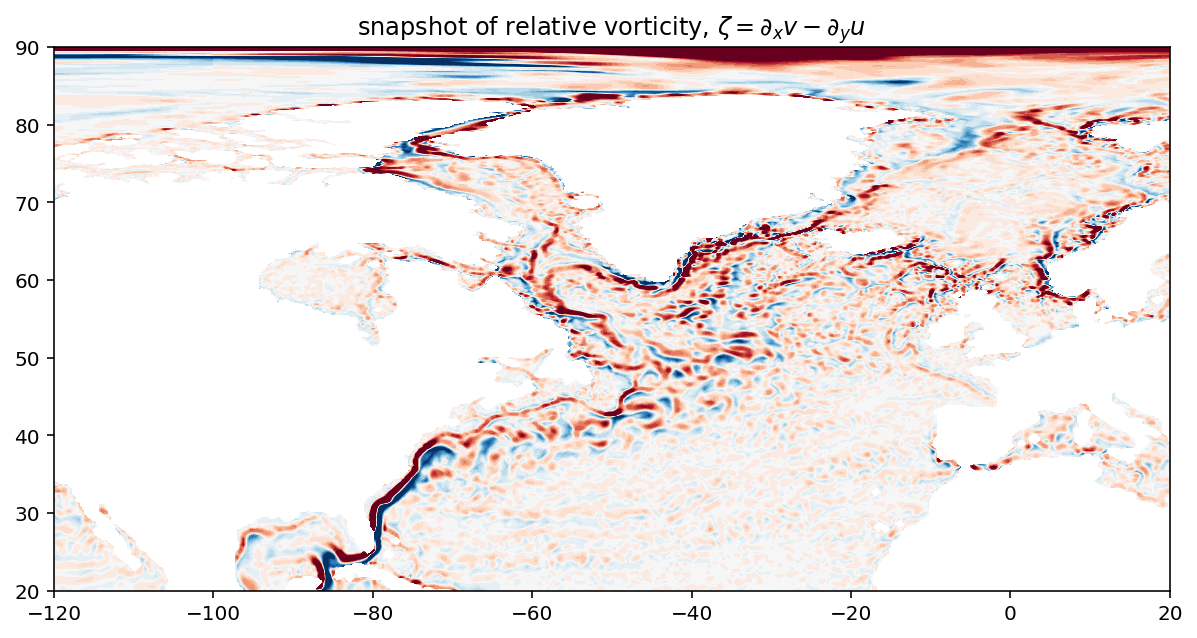

In [11]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.contourf(lon, lat, ζ_naive.values, levels=levels, cmap="RdBu_r", vmin=-maxvalue, vmax=maxvalue, extend='both')
ax.set_title("snapshot of relative vorticity, $\zeta = \partial_x v - \partial_y u$");
plt.xlim(-120, 20)
plt.ylim(20, 90);

This method is sort of OK below 65N where the complications of the tripolar grid do not enter. But even south of 65N this method gives a rough estimate. It's OK for visualising but it should **not** be used in computing, e.g., vorticity budgets.

## Method 2: replicating how MOM5 computes `vorticity_z`

Looking at [MOM5 code](https://github.com/mom-ocean/MOM5/blob/64990e1de853a175335848b67b580363053a79b4/src/mom5/ocean_diag/ocean_velocity_diag.F90#L1172-L1183) and by doing some translation from Fortran code to "english" we can see that the models computes `vorticity_z` using:

$$ \zeta(i, j, k) = \frac1{2}\Big[ \underbrace{ \frac{v(i,j,k) - v(i-1,j,k)}{\delta x_{N}(i,j,k)} }_{\approx \partial_x v(i,j,k)} +  \underbrace{\frac{v(i,j-1,k) - v(i-1,j-1,k)}{\delta x_{N}(i,j-1,k)}}_{\approx \partial_x v(i,j-1,k)} \Big] -  \frac1{2}\Big[ \underbrace{ \frac{u(i,j,k) - u(i,j-1,k)}{\delta y_{E}(i,j,k)} }_{\approx \partial_y u(i,j,k)} +  \underbrace{\frac{u(i-1,j,k) - u(i-1,j-1,k)}{\delta y_{E}(i-1,j,k)}}_{\approx \partial_x v(i,j-1,k)} \Big].$$

Above, $(i, j, k)$ refers to the grid-point indices for directions $x, y, z$ respectively.

In [12]:
ds_grid = xr.open_mfdataset('/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/output000/ocean/ocean_grid.nc', combine='by_coords')
ds = xr.merge([u, v, ds_grid])

After a lot of fiddling with indiced you can confirm that the right way to compute $\delta x_N$ and $\delta y_E$ from above is:

In [13]:
inverse_dxtn = 0.5*(1/ds.dxu + np.roll(1/ds.dxu, 1, axis=1))
inverse_dyte = 0.5*(1/ds.dyu + np.roll(1/ds.dyu, 1, axis=0))

... and with that we can now compute `ζ_mom5` which is the vorticity as exactly the way is computed by the model:

In [14]:
vx_ijk = (ds.v - np.roll(ds.v, 1, axis=1))*inverse_dxtn
uy_ijk = (ds.u - np.roll(ds.u, 1, axis=0))*inverse_dyte

vx = 0.5*( vx_ijk + np.roll(vx_ijk, 1, axis=0) )
uy = 0.5*( uy_ijk + np.roll(uy_ijk, 1, axis=1) )

ζ_mom5 = vx-uy

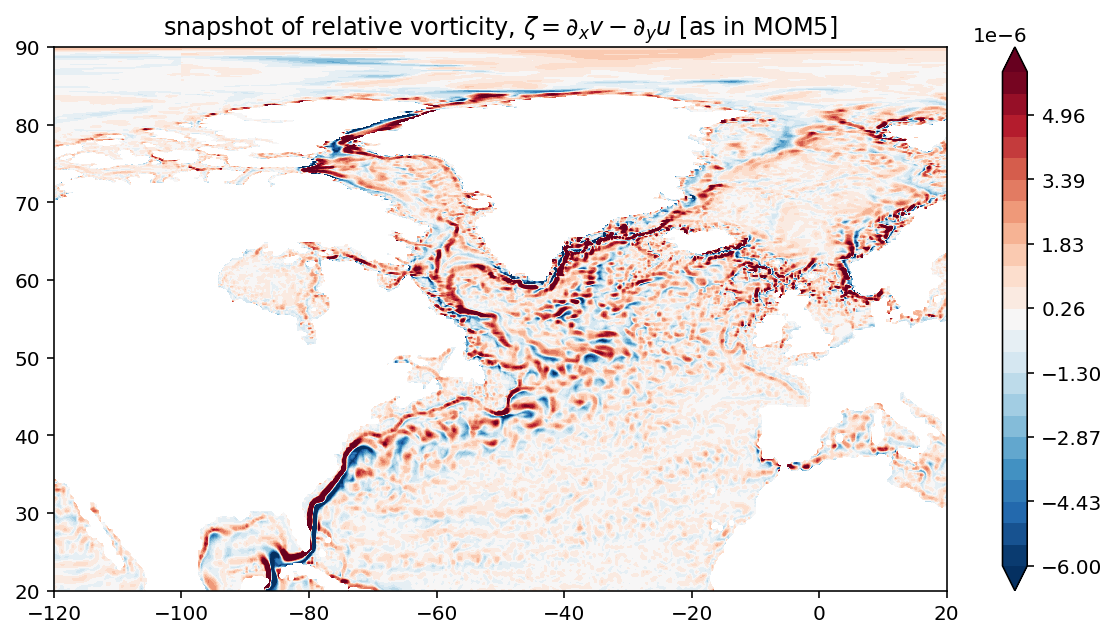

In [15]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
p = ax.contourf(lon, lat, ζ_mom5.values, levels=levels, cmap="RdBu_r", vmin=-maxvalue, vmax=maxvalue, extend='both')
ax.set_title("snapshot of relative vorticity, $\zeta = \partial_x v - \partial_y u$ [as in MOM5]");
plt.colorbar(p, extend='both')
plt.xlim(-120, 20)
plt.ylim(20, 90);

Note that the Arctic region now looks more "reasonable".

## Method 3: Using `xgcm` to replicate MOM5's calculation for `vorticity_z`

In [16]:
import xgcm
print("xgcm version ", xgcm.__version__)

xgcm version  0.3.0


In [17]:
folder = '/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/output000/ocean/'
grid = xr.open_mfdataset(folder+'ocean_grid.nc', combine='by_coords')

ds = xr.merge([u, v, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])

In [18]:
ζ_xgcm = ( grid.interp( grid.diff(ds.v, 'X') / grid.interp(ds.dxu, 'X'), 'Y', boundary='extend')
          - grid.interp( grid.diff(ds.u, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'X') )

ζ_xgcm = ζ_xgcm.rename('Relative Vorticity')
ζ_xgcm.attrs['long_name'] = 'Relative Vorticity, ∂v/∂x-∂u/∂y'
ζ_xgcm.attrs['units'] = 's-1'

Let's plot it...

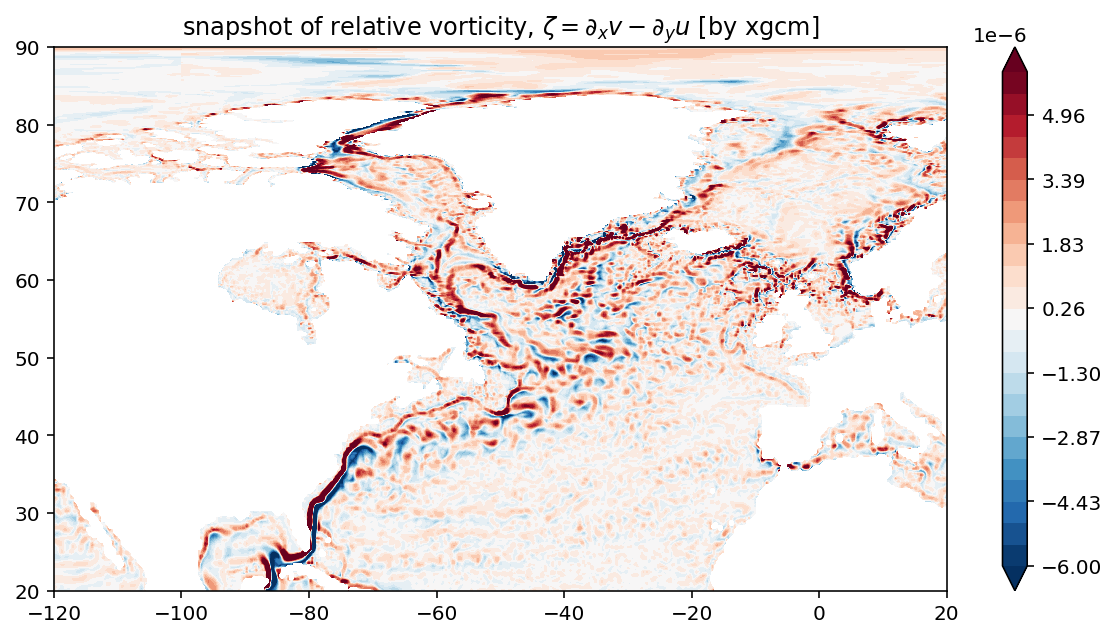

In [19]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
p = ax.contourf(lon, lat, ζ_xgcm.values, levels=levels, cmap="RdBu_r", vmin=-maxvalue, vmax=maxvalue, extend='both')
ax.set_title("snapshot of relative vorticity, $\zeta = \partial_x v - \partial_y u$ [by xgcm]");
plt.colorbar(p, extend='both')
plt.xlim(-120, 20)
plt.ylim(20, 90);

Looks OK and it was definitely easier than method 2.

## Comparisson of three methods

Now let's be thorough and compare the vorticities computed via the three methods.

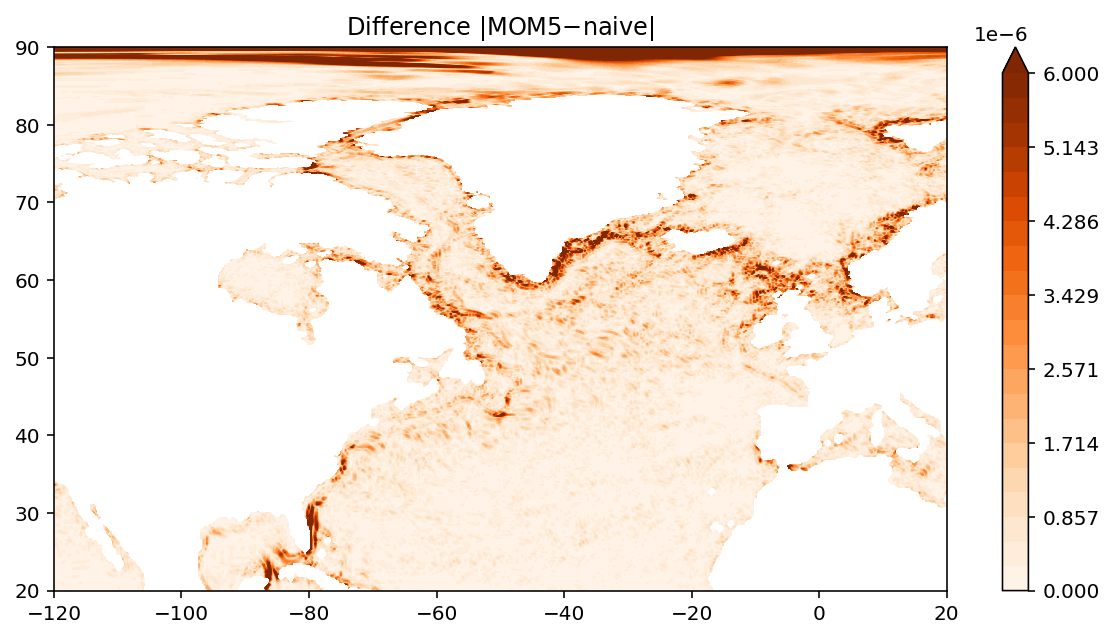

In [20]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
p = ax.contourf(lon, lat, np.abs(ζ_mom5.values-ζ_naive.values), levels=np.linspace(0, maxvalue, 22), cmap="Oranges", vmin=0, vmax=maxvalue, extend='max')
ax.set_title("Difference $|$MOM5$-$naive$|$");
plt.colorbar(p, extend='both')
plt.xlim(-120, 20)
plt.ylim(20, 90);

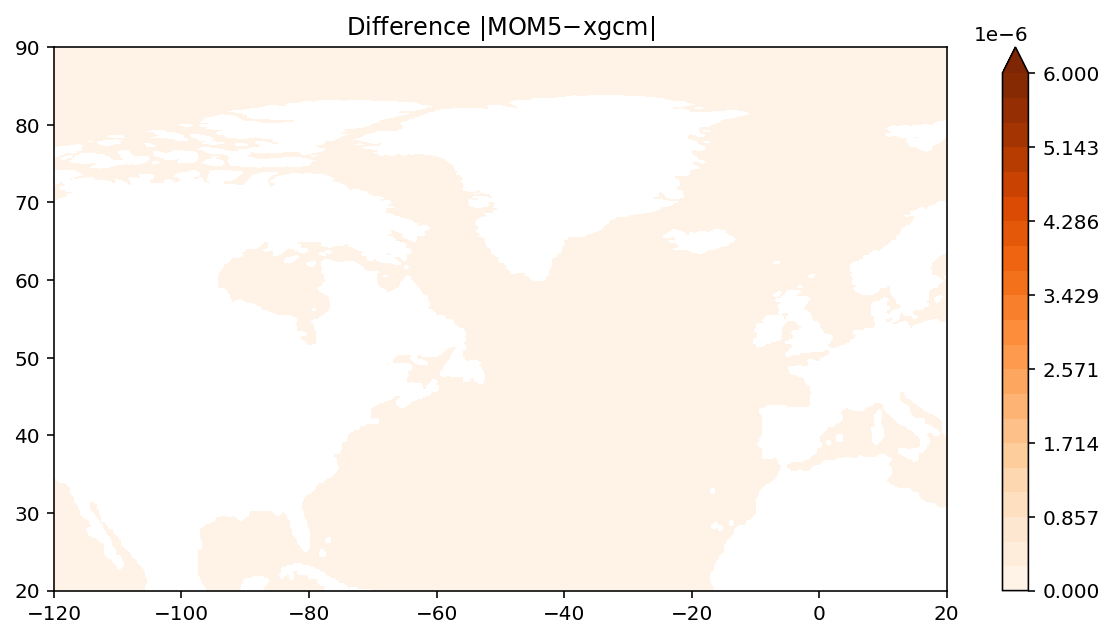

In [21]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
p = ax.contourf(lon, lat, np.abs(ζ_mom5.values-ζ_xgcm.values), levels=np.linspace(0, maxvalue, 22), cmap="Oranges", vmin=0, vmax=maxvalue, extend='max')
ax.set_title("Difference $|$MOM5$-$xgcm$|$");
plt.colorbar(p, extend='max')
plt.xlim(-120, 20)
plt.ylim(20, 90);

Indeed the `xgcm` method gives **the same** as the `MOM5` code.

The only (small) caveat here is that we don't seem to have confirmed that indeed `ζ_mom5` corresponds exactly to the `vorticity_z` that the model outputs. A way to do that is to run any model just for 1 day, save `u`, `v` and `vorticity_z` and then confirm that the `ζ_mom5` computation from method 2 is precisely `vorticity_z`.

[We have actually done what is suggested above and confirmed that `ζ_xgcm` **is** `vorticity_z` (up to machine precision). However for brevity this comparisson is not included here.]

## Further Potential Improvements

`xgcm` has a functionality to perform derivatives and interpolations using the grid metrics. Implementing that would simplify the vorticity calculations **even more**, e.g.,

```python
ζ_xgcm = grid.derivative(ds.v, 'X') - grid.derivative(ds.u, 'Y')

```